In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "nIPC" => ["Radial Glia", "Nbl1", "GlialProg"],
    "RadialGlia" => "RadialGlia2",
    "RadialGlia2" => "ImmAstro",
    "GlialProg" => "OPC",
    "Nbl1" => "Nbl2",
    "Nbl2" => ["CA", "ImmGranule1"],
    "ImmGranule1" => "ImmGranule2",
    "ImmGranule2" => "Granule",
    "CA" => ["CA1-Sub", "CA2-3-4"]
)

Dict{String, Any} with 9 entries:
  "RadialGlia2" => "ImmAstro"
  "GlialProg"   => "OPC"
  "Nbl1"        => "Nbl2"
  "CA"          => ["CA1-Sub", "CA2-3-4"]
  "Nbl2"        => ["CA", "ImmGranule1"]
  "nIPC"        => ["Radial Glia", "Nbl1", "GlialProg"]
  "ImmGranule1" => "ImmGranule2"
  "RadialGlia"  => "RadialGlia2"
  "ImmGranule2" => "Granule"

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 18213 ✕ 2000

In [8]:
intrinsic_labels = sort(unique(julovelo_adata.obs.clusters))

14-element Vector{String}:
 "CA"
 "CA1-Sub"
 "CA2-3-4"
 "GlialProg"
 "Granule"
 "ImmAstro"
 "ImmGranule1"
 "ImmGranule2"
 "Nbl1"
 "Nbl2"
 "OPC"
 "RadialGlia"
 "RadialGlia2"
 "nIPC"

In [9]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

9-element Vector{String}:
 "CA"
 "GlialProg"
 "ImmGranule1"
 "ImmGranule2"
 "Nbl1"
 "Nbl2"
 "RadialGlia"
 "RadialGlia2"
 "nIPC"

In [10]:
intrinsic_palettes = Dict("CA"=> "#023fa5",
 "CA1-Sub"=> "#7d87b9",
 "CA2-3-4"=> "#bec1d4",
 "GlialProg"=> "#d6bcc0",
 "Granule"=> "#bb7784",
 "ImmAstro"=> "#8e063b",
 "ImmGranule1"=> "#4a6fe3",
 "ImmGranule2"=> "#8595e1",
 "Nbl1"=> "#b5bbe3",
 "Nbl2"=> "#e6afb9",
 "OPC"=> "#e07b91",
 "RadialGlia"=> "#d33f6a",
 "RadialGlia2"=> "#11c638",
 "nIPC"=> "#8dd593")

Dict{String, String} with 14 entries:
  "CA2-3-4"     => "#bec1d4"
  "CA"          => "#023fa5"
  "Nbl1"        => "#b5bbe3"
  "Nbl2"        => "#e6afb9"
  "CA1-Sub"     => "#7d87b9"
  "ImmGranule1" => "#4a6fe3"
  "RadialGlia2" => "#11c638"
  "GlialProg"   => "#d6bcc0"
  "Granule"     => "#bb7784"
  "nIPC"        => "#8dd593"
  "ImmAstro"    => "#8e063b"
  "ImmGranule2" => "#8595e1"
  "RadialGlia"  => "#d33f6a"
  "OPC"         => "#e07b91"

In [11]:
extrinsic_palettes = Dict("CA"=> "#023fa5",
 "GlialProg"=> "#d6bcc0",
 "ImmGranule1"=> "#4a6fe3",
 "ImmGranule2"=> "#8595e1",
 "Nbl1"=> "#b5bbe3",
 "Nbl2"=> "#e6afb9",
 "RadialGlia"=> "#d33f6a",
 "RadialGlia2"=> "#11c638",
 "nIPC"=> "#8dd593")

Dict{String, String} with 9 entries:
  "RadialGlia2" => "#11c638"
  "CA"          => "#023fa5"
  "GlialProg"   => "#d6bcc0"
  "Nbl1"        => "#b5bbe3"
  "Nbl2"        => "#e6afb9"
  "nIPC"        => "#8dd593"
  "ImmGranule1" => "#4a6fe3"
  "ImmGranule2" => "#8595e1"
  "RadialGlia"  => "#d33f6a"

In [12]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [13]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [14]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; xkey = "X_tsne", vkey = "velocity_tsne")
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_tsne", vkey = "velocity_tsne")
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_tsne", vkey = "velocity_tsne")
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 14 entries:
  "CA2-3-4"     => [0.591901, 0.941247, 0.600782, 0.989329, 0.449691, 0.874386,…
  "Nbl1"        => [0.903396, 0.750159, -0.191472, -0.435275, 0.419284, -0.4537…
  "Nbl2"        => [-0.0507762, 0.326793, 0.317755, 0.286795, -0.0633249, 0.777…
  "RadialGlia2" => [0.0804945, 0.23479, -0.531136, 0.9482, 0.999998, 0.977791, …
  "ImmAstro"    => [0.209863, -0.0575037, -0.325768, 0.840569, 0.649771, 0.7329…
  "ImmGranule2" => [0.266708, 0.490432, 0.85705, 0.0700203, 0.9679, 0.648701, 0…
  "CA"          => [0.479777, 0.5983, -0.3315, 0.689363, -0.0481116, -0.0491304…
  "CA1-Sub"     => [0.23198, 0.909245, 0.521965, 0.0425265, 0.96881, 0.803813, …
  "ImmGranule1" => [-0.785172, 0.701967, 0.213472, -0.182742, -0.191616, 0.1730…
  "GlialProg"   => [0.320973, 0.311286, 0.983707, 0.616736, -0.353753, 0.455544…
  "Granule"     => [-0.116694, 0.23883, 0.990062, 0.807571, 0.547293, 0.0413193…
  "nIPC"        => [0.434047, 0.179817, 0.897423, 0.985726, -0

In [15]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[0.9995644, -0.13600564, 0.99904525, 0.8774007, 0.853508, 0.97609144, 0.5933101, 0.610873, 0.97896034, 0.9721937  …  0.49059847, 0.32866228, 0.4050403, 0.119421475, 0.22089592, 0.9447608, 0.8739208, 0.52301913, -0.049564295, 0.006304799], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

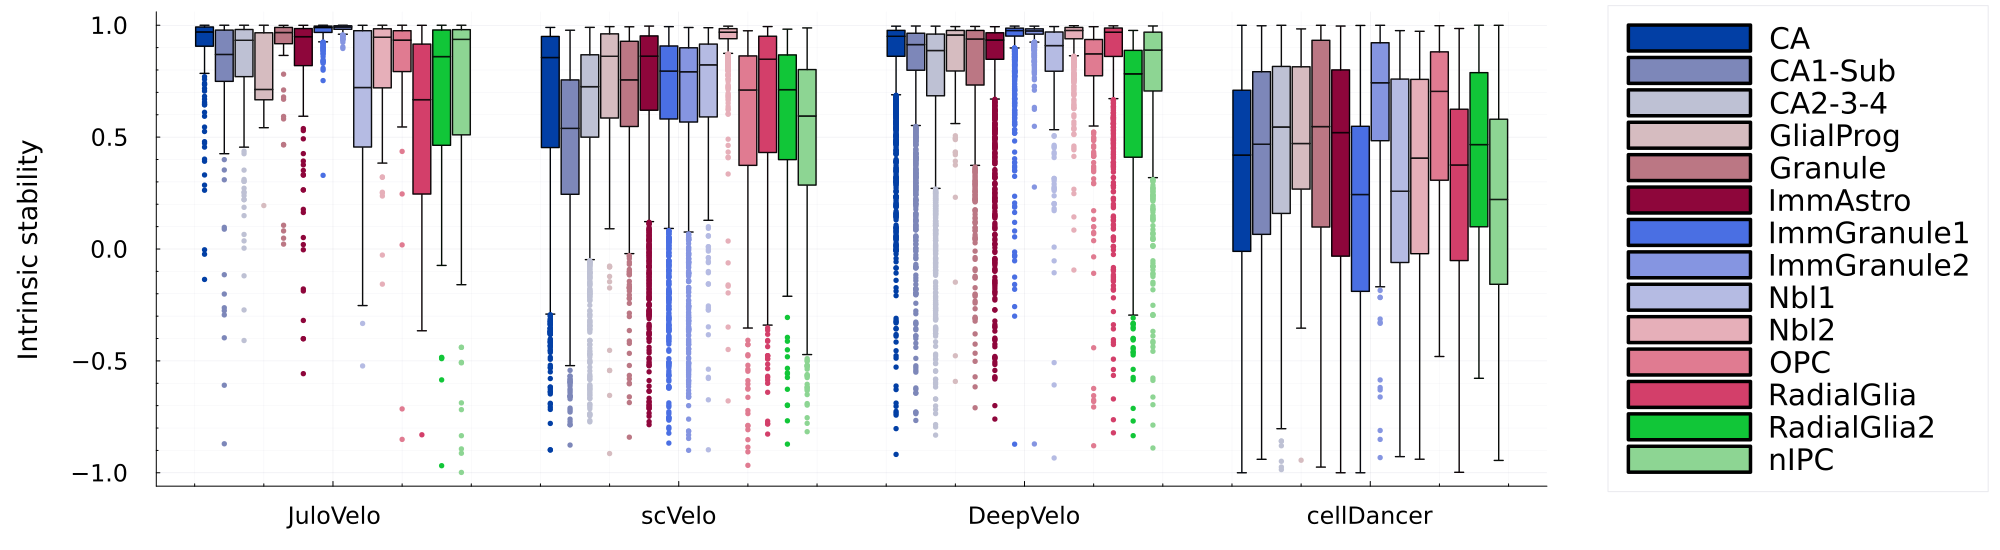

In [16]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [17]:
savefig(p, "figure/hippocampus_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/dentategyrus_lamanno/figure/hippocampus_intrinsic_stability.png"

# Extrinsic stability

In [18]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; xkey = "X_tsne", vkey = "velocity_tsne")
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_tsne", vkey = "velocity_tsne")
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_tsne", vkey = "velocity_tsne")
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 9 entries:
  "RadialGlia2" => [-0.188403, -0.414954, 0.443563, 0.111496, 0.423677, -0.8734…
  "GlialProg"   => [0.836684, 0.0155633, 0.1606, 0.955976]
  "Nbl1"        => [0.428985, 0.800168, 0.739491, 0.921368, 0.875232]
  "CA"          => [0.276106, 0.570889, 0.983089, 0.446637, 0.190674, 0.999516,…
  "Nbl2"        => [0.242836, 0.384237, 0.995453, -0.3879, 0.498068, -0.308273,…
  "nIPC"        => [0.908821, 0.928189, 0.101023, -0.91495, -0.778635, 0.129847…
  "ImmGranule1" => [-0.0574078, 0.790172, 0.341625, -0.464009, -0.436646, -0.41…
  "RadialGlia"  => [-0.0224829, -0.915492, -0.750784, -0.0674355, -0.177054, 0.…
  "ImmGranule2" => [0.97021, 0.899807, 0.496483, 0.736037, 0.0933989, 0.557234,…

In [19]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[0.3661934, -0.6354325, -0.117566206, -0.94166136, 0.6099655, -0.6526596, 0.34929594, -0.9239958, 0.9265232, 0.8103607  …  0.3527401, -0.89651835, 0.8655349, -0.6023682, -0.72024316, -0.664367, -0.7350353, -0.20427237, -0.6669756, 0.64688474], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA", "CA"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

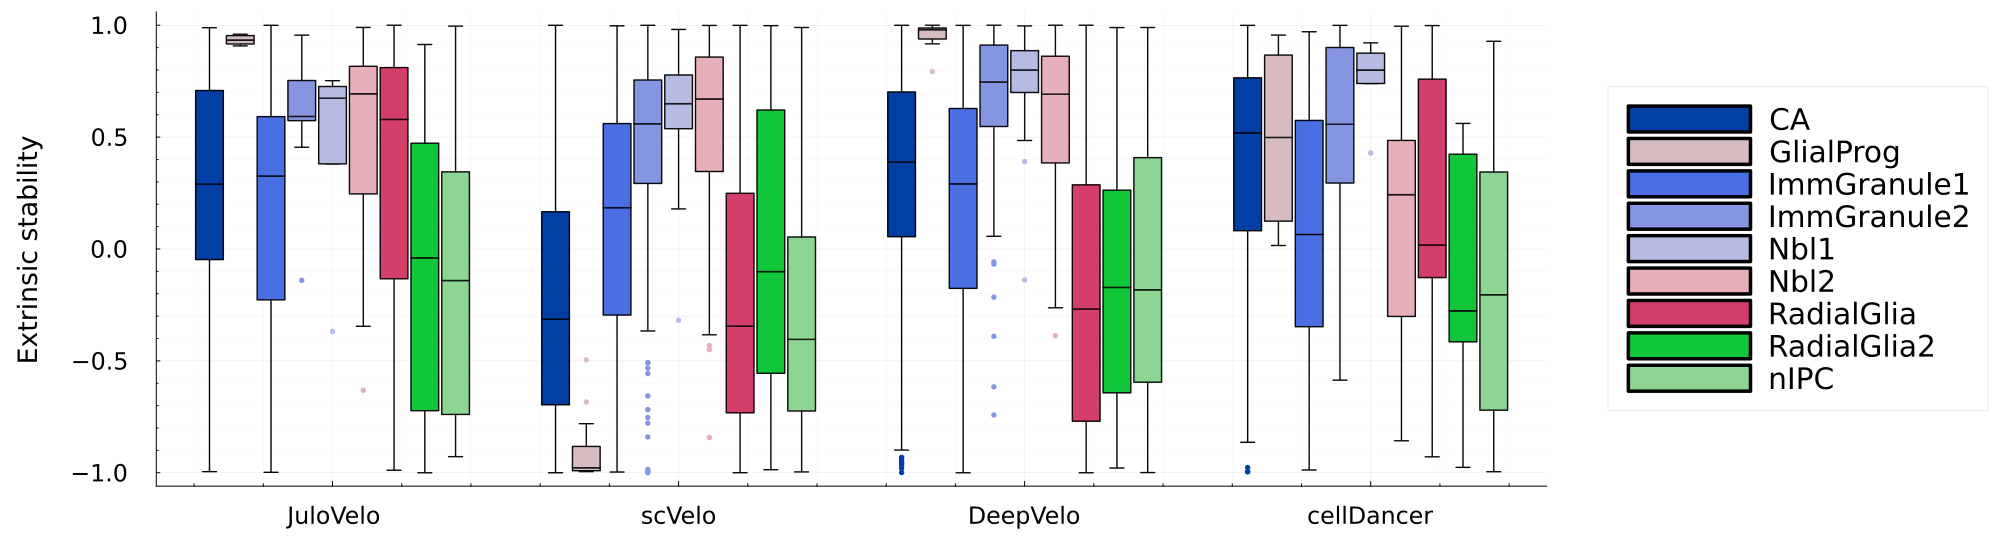

In [20]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [21]:
savefig(p, "figure/hippocampus_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/dentategyrus_lamanno/figure/hippocampus_extrinsic_stability.png"